# Model explanation with LIME

We will use the [speed dating](https://www.openml.org/d/40536) dataset and train random forest and XGoost classifiers.

In [1]:
import pandas as pd

dataset_path = 'SpeedDating.csv'

df = pd.read_csv(dataset_path, index_col=0)
df.head()


,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,intelligence_o,funny_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,interests_correlate,like,TARGET
0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,0.14,7.0,0
1,60.0,0.0,0.0,40.0,0.0,0.0,7.0,10.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,0.54,7.0,0
3,30.0,5.0,15.0,40.0,5.0,5.0,7.0,9.0,8.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,0.61,7.0,1
4,30.0,10.0,20.0,10.0,10.0,20.0,8.0,9.0,6.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,0.21,6.0,1
5,50.0,0.0,30.0,10.0,0.0,10.0,7.0,8.0,8.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,0.25,6.0,0


In [2]:
from sklearn.model_selection import train_test_split

TARGET_COL = 'TARGET'

X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


In [3]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


RandomForestClassifier()

Text(0.5, 1.0, 'Random Forest')

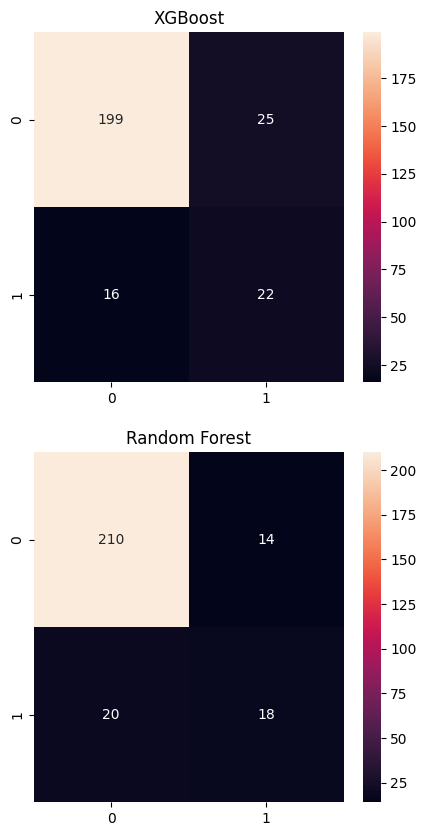

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


_, axs = plt.subplots(figsize=(5, 10), nrows=2)


y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, ax=axs[0], fmt='g')
axs[0].set_title('XGBoost')

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, ax=axs[1], fmt='g')
axs[1].set_title('Random Forest')


In [35]:
import random
from lime import lime_tabular
import dalex as dx

# Let's create explainers for both models

xgb_explainer = dx.Explainer(xgb_model, X_train, y_train)
rf_explainer = dx.Explainer(rf_model, X_train, y_train)


Preparation of a new explainer is initiated

  -> data              : 786 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 786 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x1486acb80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 7.4e-06, mean = 0.188, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.144, mean = -1.64e-05, max = 0.158
  -> model_info        : package xgboost

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 786 rows 18 cols
  -> target variable   : Parameter 'y' was a pa

/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


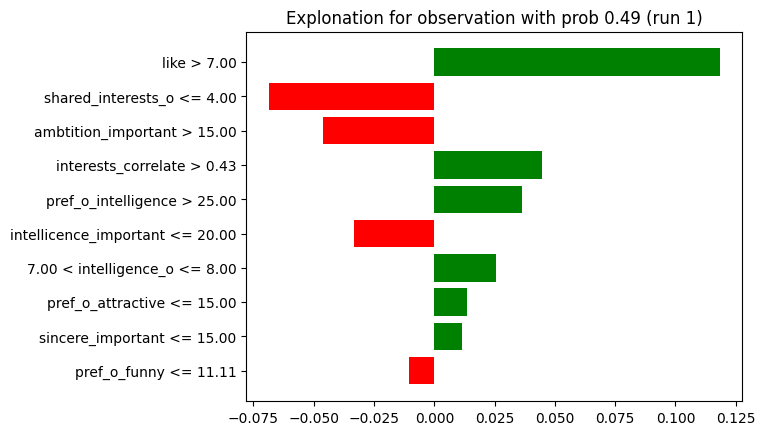

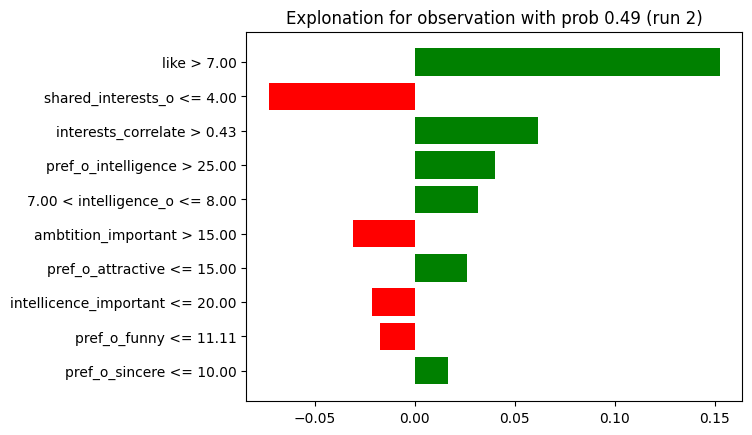

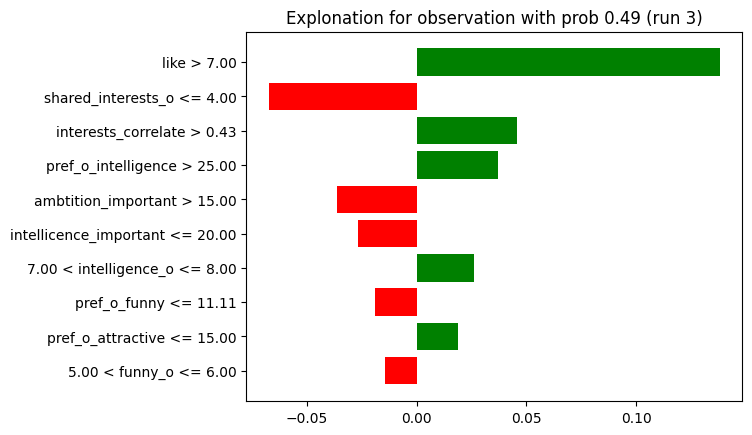

In [80]:
import matplotlib.pyplot as plt
import numpy as np

y_prob = xgb_model.predict_proba(X_test)[:, 1]

edge_case = X_test[(y_prob > 0.45) & (y_prob < 0.55)].sample(n=1).iloc[0, :]


for i in range(3):
    observation = edge_case
    exp = xgb_explainer.predict_surrogate(observation)
    proba = xgb_model.predict_proba(observation.values.reshape(1, -1))[0, 1]
    exp.plot(return_figure=True)
    _ = plt.title(f'Explonation for observation with prob {proba:.2f} (run {i+1})')


Predicted class: 0
Correct class: 0


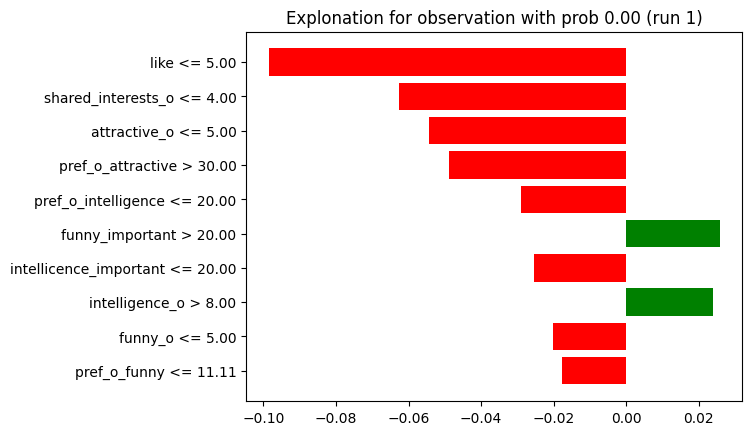

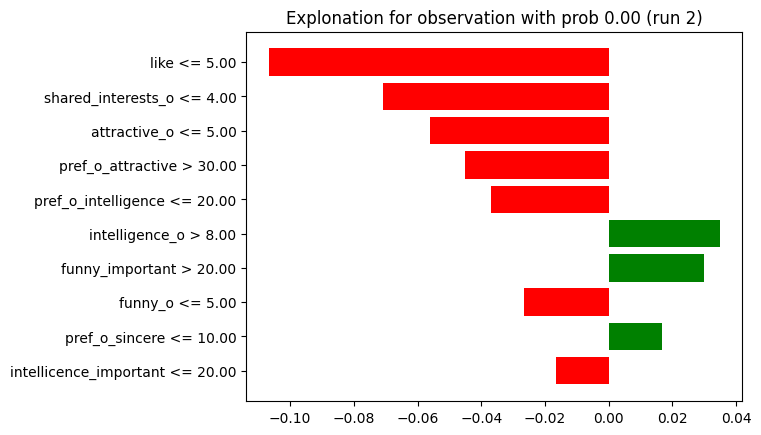

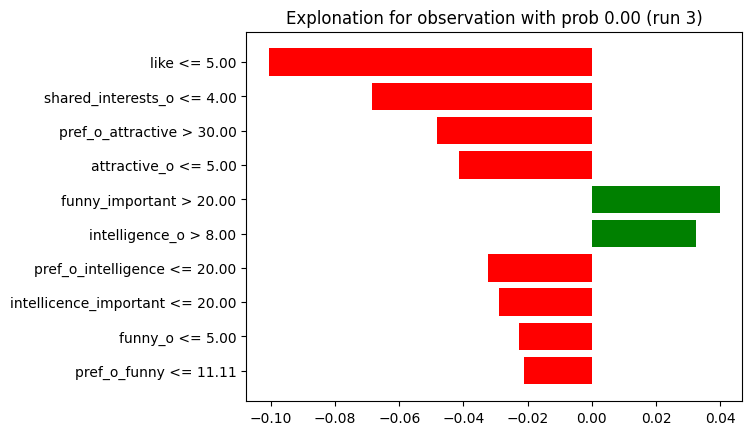

In [94]:
certain_indices = np.where((y_prob < 0.1) | (y_prob > 0.9))[0]

correct_indices = np.where(y_test == y_pred)[0]
incorrect_indices = np.where(y_test != y_pred)[0]

certain_correct_indices = np.intersect1d(certain_indices, correct_indices)
certain_incorrect_indices = np.intersect1d(certain_indices, incorrect_indices)

certain_correct = X_test.iloc[certain_correct_indices, :].sample(n=1).iloc[0, :]
certain_incorrect = X_test.iloc[certain_incorrect_indices, :].sample(n=1).iloc[0, :]


print(f'Predicted class: {xgb_model.predict(certain_correct.values.reshape(1, -1))[0]}')
print(f'Correct class: {y_test.iloc[certain_correct_indices].values[0]}')

for i in range(3):
    observation = certain_correct
    exp = xgb_explainer.predict_surrogate(observation)
    exp.plot(return_figure=True)
    proba = xgb_model.predict_proba(observation.values.reshape(1, -1))[0, 1]
    _ = plt.title(f'Explonation for observation with prob {proba:.2f} (run {i+1})')


Prediction: 1
Real: 0


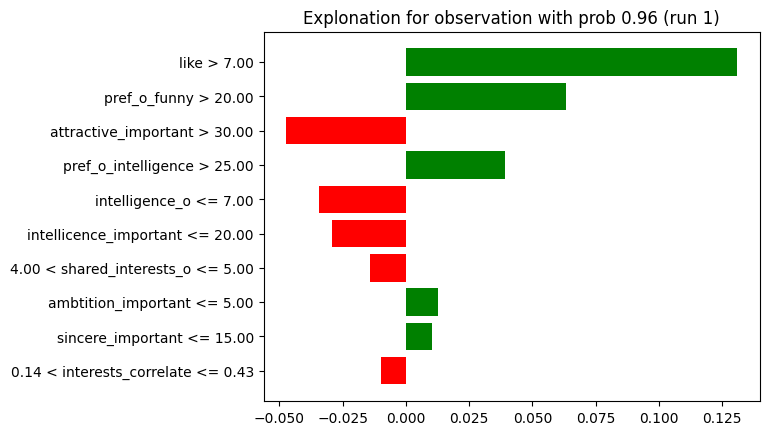

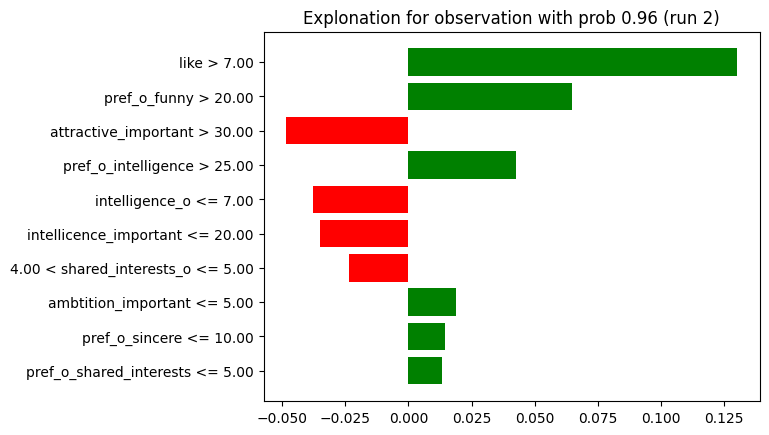

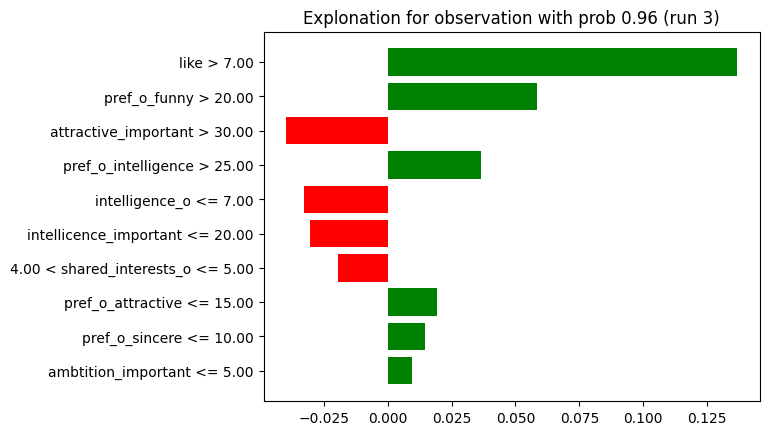

In [92]:
print(f'Prediction: {xgb_model.predict(observation.values.reshape(1, -1))[0]}')
print(f'Real: {y_test.iloc[certain_incorrect_indices].values[0]}')

for i in range(3):
    observation = certain_incorrect
    exp = xgb_explainer.predict_surrogate(observation)
    exp.plot(return_figure=True)
    proba = xgb_model.predict_proba(observation.values.reshape(1, -1))[0, 1]
    _ = plt.title(f'Explonation for observation with prob {proba:.2f} (run {i+1})')


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[1] [0]


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[1] [0]


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[1] [0]


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


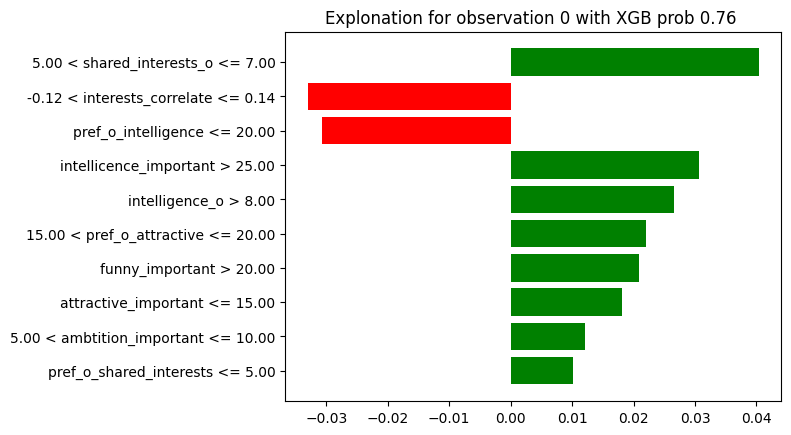

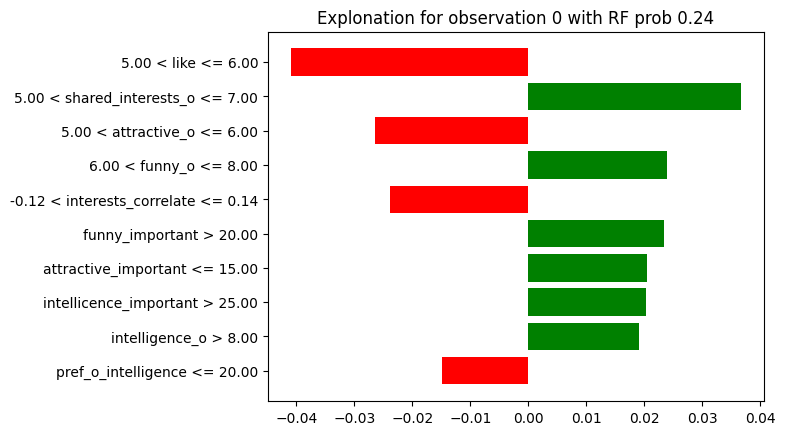

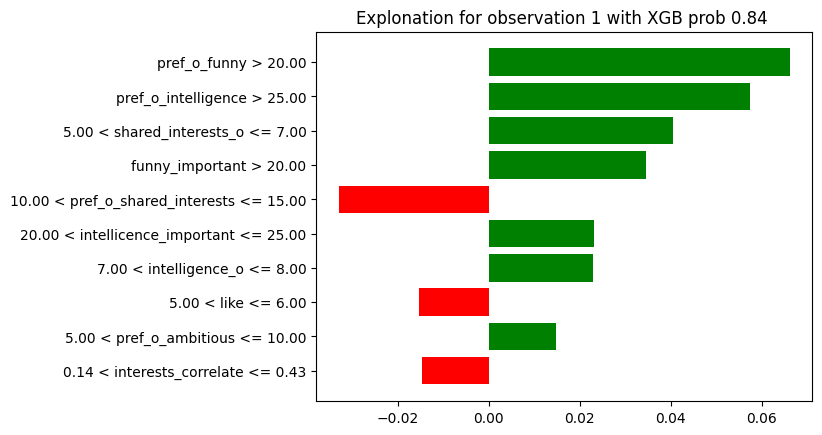

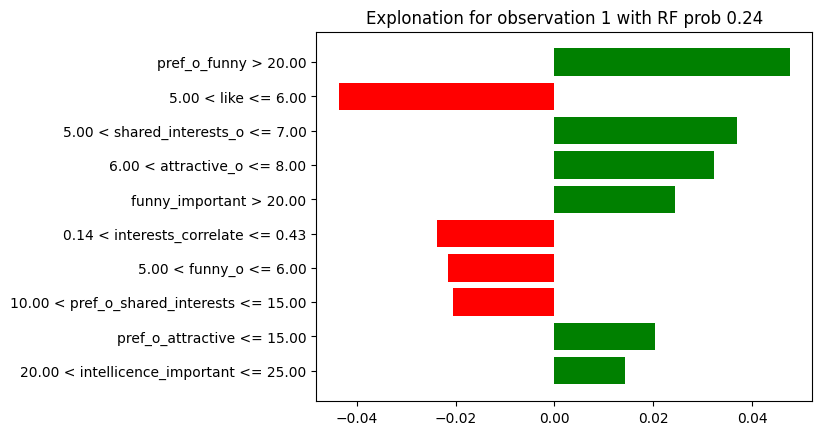

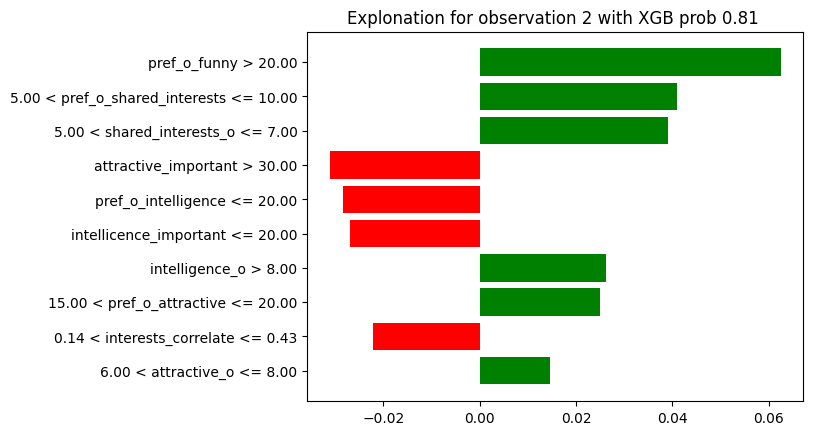

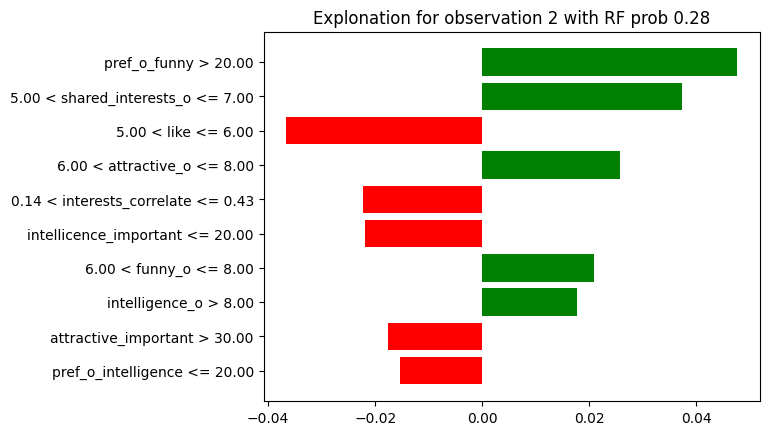

In [102]:
import numpy as np

TH = 0.3
xgb_predictions = xgb_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

disagree_indices = np.where(xgb_predictions != rf_predictions)[0]

y_prob = xgb_model.predict_proba(X_test)[:, 1]
xgb_certain_indices = np.where((y_prob < TH) | (y_prob > 1-TH))[0]

y_prob = rf_model.predict_proba(X_test)[:, 1]
rf_certain_indices = np.where((y_prob < TH) | (y_prob > 1-TH))[0]

certain_disagree_indices = np.intersect1d(
    np.intersect1d(xgb_certain_indices, rf_certain_indices), disagree_indices
)

certain_disagree_observations = X_test.iloc[certain_disagree_indices, :].sample(n=3)

for i in range(3):
    observation = certain_disagree_observations.iloc[i, :]
    print(xgb_model.predict(observation.values.reshape(1, -1)), rf_model.predict(observation.values.reshape(1, -1)))

    exp = xgb_explainer.predict_surrogate(observation)
    exp.plot(return_figure=True)
    proba = xgb_model.predict_proba(observation.values.reshape(1, -1))[0, 1]
    _ = plt.title(f'Explonation for observation {i} with XGB prob {proba:.2f} ')
    plt.savefig(f'img/different_classes_ob_{i}_xgb.png')

    exp = rf_explainer.predict_surrogate(observation)
    exp.plot(return_figure=True)
    proba = rf_model.predict_proba(observation.values.reshape(1, -1))[0, 1]
    _ = plt.title(f'Explonation for observation {i} with RF prob {proba:.2f}')
    plt.savefig(f'img/different_classes_ob_{i}_rf.png')


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0] [0]


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0] [0]


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0] [0]


/Users/robertlaskowski/Desktop/eXplainableMachineLearning-2024/venv/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


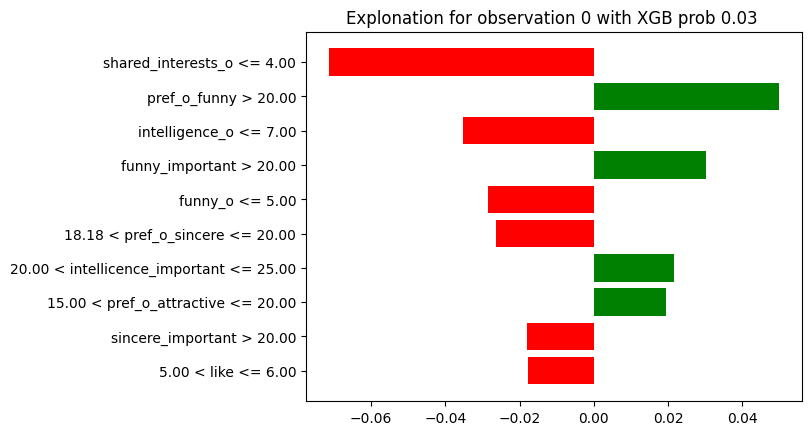

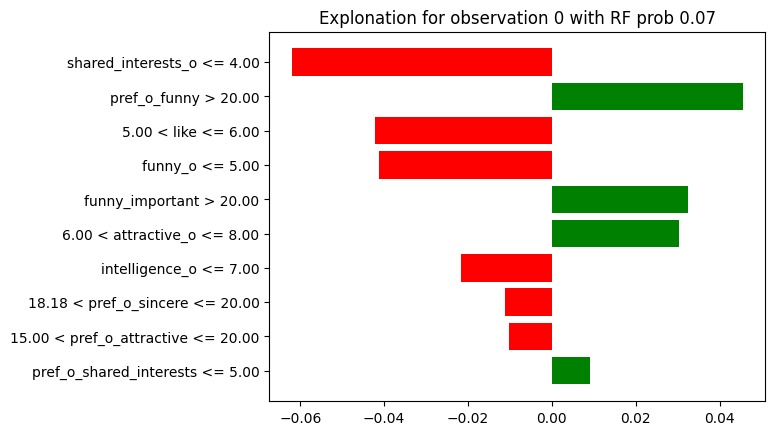

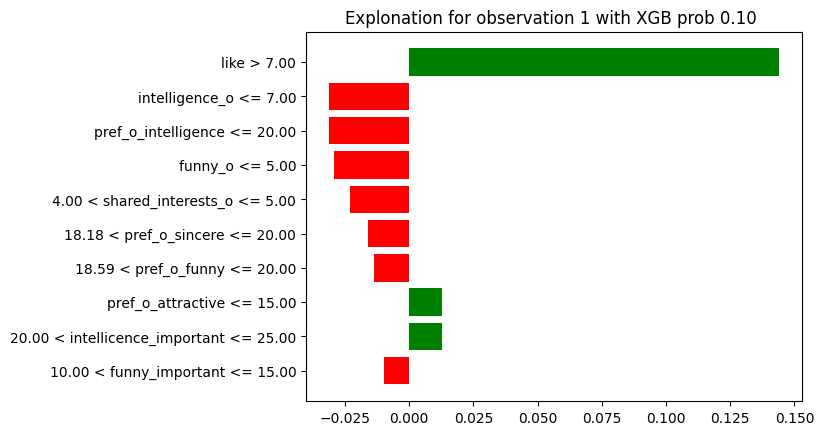

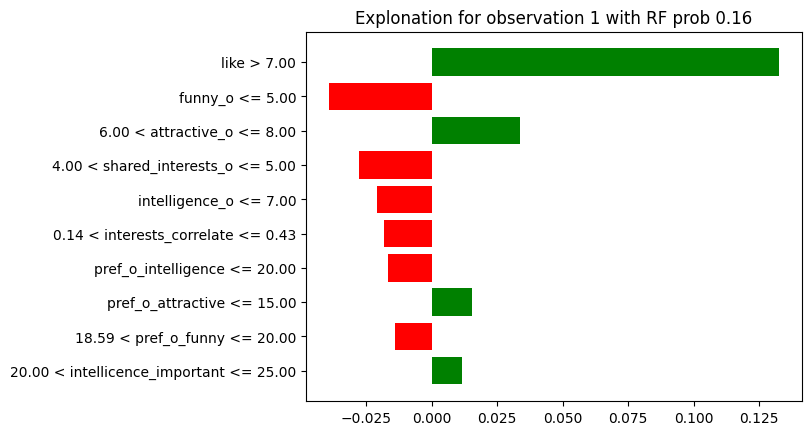

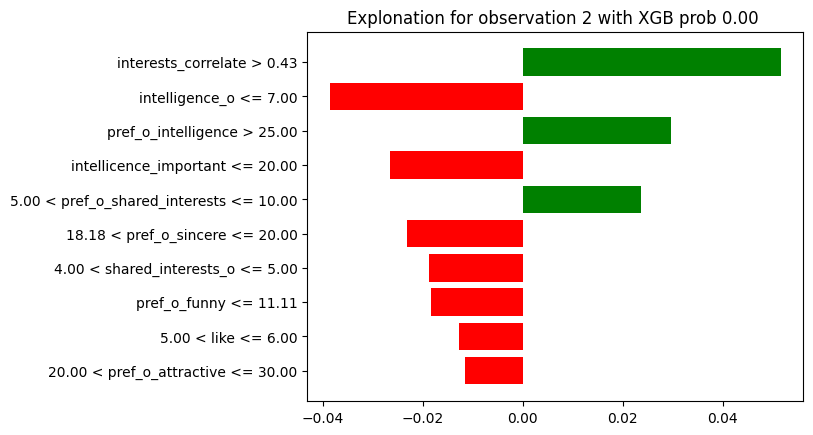

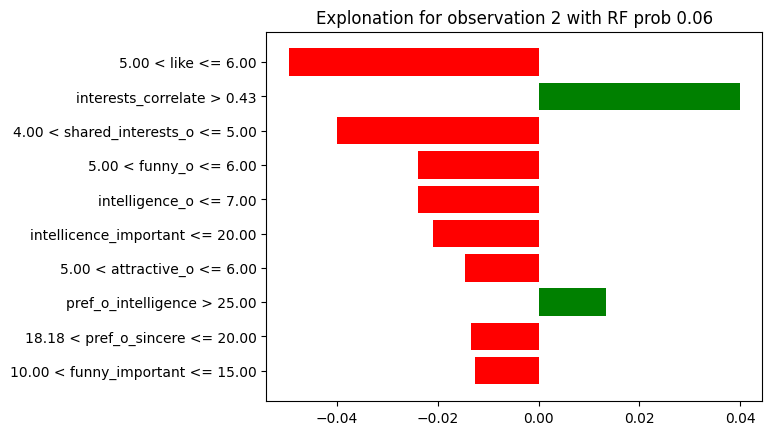

In [103]:
agree_indices = np.where(xgb_predictions == rf_predictions)[0]

certain_agree_indices = np.intersect1d(
    np.intersect1d(xgb_certain_indices, rf_certain_indices), agree_indices
)

certain_agree_observations = X_test.iloc[certain_agree_indices, :].sample(n=3)

for i in range(3):
    observation = certain_agree_observations.iloc[i, :]
    print(xgb_model.predict(observation.values.reshape(1, -1)), rf_model.predict(observation.values.reshape(1, -1)))

    exp = xgb_explainer.predict_surrogate(observation)
    exp.plot(return_figure=True)
    proba = xgb_model.predict_proba(observation.values.reshape(1, -1))[0, 1]
    _ = plt.title(f'Explonation for observation {i} with XGB prob {proba:.2f} ')
    plt.savefig(f'img/same_classes_ob_{i}_xgb.png')

    exp = rf_explainer.predict_surrogate(observation)
    exp.plot(return_figure=True)
    proba = rf_model.predict_proba(observation.values.reshape(1, -1))[0, 1]
    _ = plt.title(f'Explonation for observation {i} with RF prob {proba:.2f}')
    plt.savefig(f'img/same_classes_ob_{i}_rf.png')
